In [16]:
from IPython.display import display
from spells import load_data, datetime_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegressionCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import os

In [17]:
data = datetime_split(pd.read_csv('data/crime_data2.csv'))
print(data.shape)
data.head()

(236380, 15)


,X,Y,TARGET,GeoIdBlockCensus,TotalAreaBlockCensus,BusStopsCount,DistanceBusStop,CSA2020,YEAR,MONTH,DAY,DOW,HOUR,MINUTE,SECOND
0,-76.624824,39.252974,ASALTO,245102502072001,69042.148089,0.0,9.767034e+06,Cherry Hill,2018,4,2,0,4,0,0
1,-76.592225,39.343284,HURTO,245102709031016,4196.749506,0.0,9.770183e+06,Northwood,2019,2,1,4,8,0,0
2,-76.625705,39.284369,HURTO,245102201001005,15926.414256,0.0,9.769345e+06,Inner Harbor/Federal Hill,2017,9,27,2,21,0,0
3,-76.478282,39.270194,FALSO,240054525001001,493438.317358,0.0,9.753389e+06,NaN,2017,3,21,1,11,0,0
4,-76.576006,39.291228,ROBO,245100102004002,7452.528531,1.0,9.765019e+06,Patterson Park North & East,2017,3,7,1,2,0,0


In [18]:
data = data.drop(columns=['MINUTE', 'SECOND'])

# Data Exploration

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236380 entries, 0 to 236379
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   X                     236380 non-null  float64
 1   Y                     236380 non-null  float64
 2   TARGET                236380 non-null  object 
 3   GeoIdBlockCensus      236380 non-null  int64  
 4   TotalAreaBlockCensus  236380 non-null  float64
 5   BusStopsCount         236380 non-null  float64
 6   DistanceBusStop       236380 non-null  float64
 7   CSA2020               214417 non-null  object 
 8   YEAR                  236380 non-null  int64  
 9   MONTH                 236380 non-null  int64  
 10  DAY                   236380 non-null  int64  
 11  DOW                   236380 non-null  int64  
 12  HOUR                  236380 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 23.4+ MB


In [20]:
data.describe()

,X,Y,GeoIdBlockCensus,TotalAreaBlockCensus,BusStopsCount,DistanceBusStop,YEAR,MONTH,DAY,DOW,HOUR
count,236380.000000,236380.000000,2.363800e+05,2.363800e+05,236380.000000,2.363800e+05,236380.000000,236380.000000,236380.000000,236380.000000,236380.000000
mean,-76.614444,39.281383,2.446467e+14,7.807390e+05,0.617362,1.052360e+07,2018.823026,6.637689,15.722785,2.981699,12.735731
std,0.055628,0.101894,1.439582e+12,7.136236e+06,1.391997,2.613257e+06,1.404120,3.394627,8.778661,1.996503,7.027608
min,-76.780542,38.704959,2.400370e+14,5.548308e+02,0.000000,9.720192e+06,2017.000000,1.000000,1.000000,0.000000,0.000000
25%,-76.651820,39.284412,2.451008e+14,8.036719e+03,0.000000,9.766743e+06,2018.000000,4.000000,8.000000,1.000000,8.000000
50%,-76.613901,39.299279,2.451016e+14,1.442424e+04,0.000000,9.770235e+06,2019.000000,7.000000,16.000000,3.000000,14.000000
75%,-76.582176,39.323776,2.451026e+14,4.421261e+04,1.000000,9.774429e+06,2020.000000,10.000000,23.000000,5.000000,19.000000
max,-76.383051,39.399826,2.451028e+14,1.611773e+08,17.000000,1.958562e+07,2021.000000,12.000000,31.000000,6.000000,23.000000


In [21]:
data.TARGET.value_counts(normalize=True)

HURTO     0.391078
ASALTO    0.293781
ROBO      0.216952
FALSO     0.098189
Name: TARGET, dtype: float64

print("Min X")
display(data[data["X"] == data.X.min()])
print("Max X")
display(data[data["X"] == data.X.max()])
print("Min Y")
display(data[data["Y"] == data.Y.min()])
print("Max Y")
display(data[data["Y"] == data.Y.max()])

La coordenada donde se encuentra el X.max() está fuera de Baltimore City, puede ser uno de los registros falsos o que la data corresponda a Baltimore County.

Lo mismo ocurre con el Y.min().

También con el Y.max().

Efectivamente los datos corresponden a Baltimore City, los que dicen FALSO fueron agregados intencionalmente fuera del área de Baltimore City para dificultar la predicción.

## Correlation Matrix

/tmp/ipykernel_1980/2266396926.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


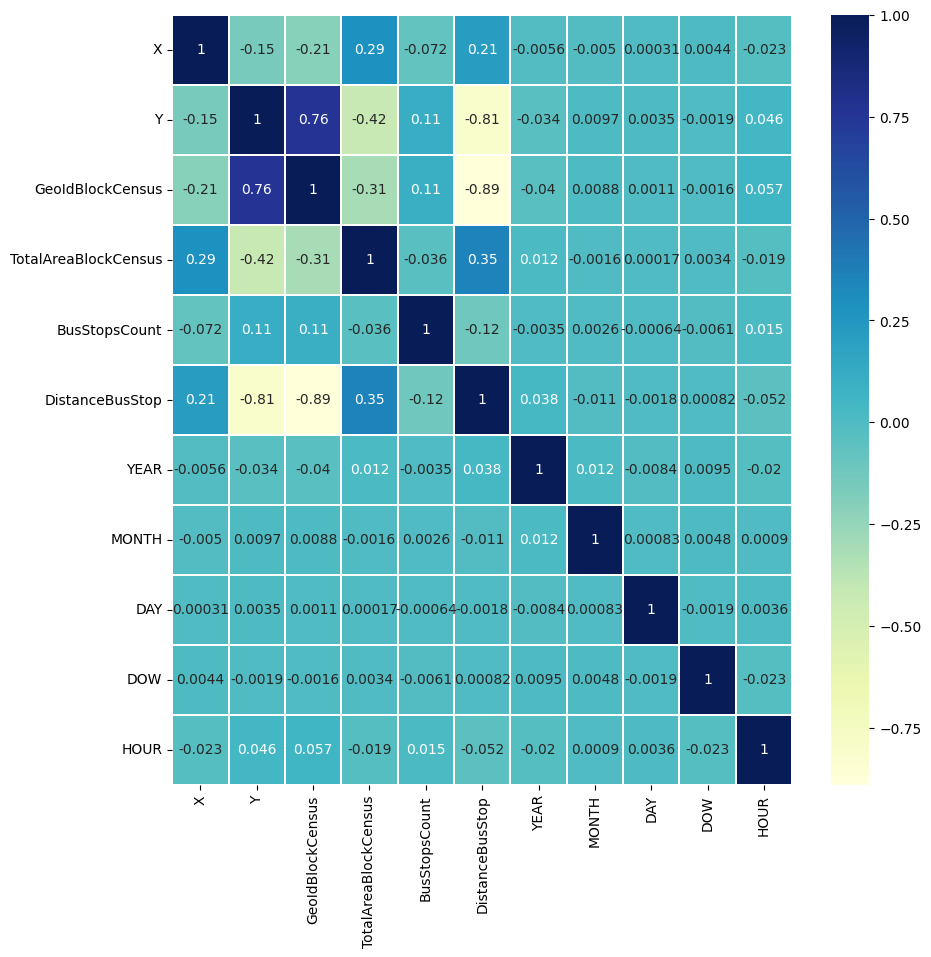

In [22]:
# plot correlation matrix
corr = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot = True, ax=ax, cmap="YlGnBu", linewidths=0.1)
plt.show()


# Feature Engineering


In [23]:
data2 = data.copy()

In [24]:
data2.max()

/tmp/ipykernel_1980/1405164346.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data2.max()


X                            -76.383051
Y                             39.399826
TARGET                             ROBO
GeoIdBlockCensus        245102806003029
TotalAreaBlockCensus      161177304.126
BusStopsCount                      17.0
DistanceBusStop         19585621.802688
YEAR                               2021
MONTH                                12
DAY                                  31
DOW                                   6
HOUR                                 23
dtype: object

# Scale data

In [25]:
# scale data
variables = [
    'X',
    'Y',
    'YEAR',
    'MONTH',
    'DAY',
    'DOW',
    'GeoIdBlockCensus',
    'TotalAreaBlockCensus',
    'BusStopsCount',
    'DistanceBusStop',
]
scaler = StandardScaler()
data2[variables] = scaler.fit_transform(data2[variables])
data2.head()

,X,Y,TARGET,GeoIdBlockCensus,TotalAreaBlockCensus,BusStopsCount,DistanceBusStop,CSA2020,YEAR,MONTH,DAY,DOW,HOUR
0,-0.186593,-0.278815,ASALTO,0.316641,-0.099730,-0.443509,-0.289509,Cherry Hill,-0.586152,-0.777021,-1.563201,-1.493464,4
1,0.399436,0.607501,HURTO,0.316785,-0.108817,-0.443509,-0.288304,Northwood,0.126039,-1.366188,-1.677114,0.510043,8
2,-0.202423,0.029304,HURTO,0.316432,-0.107173,-0.443509,-0.288625,Inner Harbor/Federal Hill,-1.298344,0.695898,1.284619,-0.491710,21
3,2.447744,-0.109812,FALSO,-3.189923,-0.040260,-0.443509,-0.294731,NaN,-1.298344,-1.071604,0.601142,-0.992587,11
4,0.690998,0.096622,ROBO,0.314974,-0.108361,0.274885,-0.290280,Patterson Park North & East,-1.298344,-1.071604,-0.993637,-0.992587,2


# Label Encoding

In [26]:
# label encoding

variables2 = ["TARGET", 'CSA2020']
from sklearn.preprocessing import LabelEncoder

les = {}
for var in variables2:
    le = LabelEncoder()
    data2[var] = le.fit_transform(data2[var])
    les[var] = le

le = les["TARGET"]

# Modeling

## Train test split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data2.drop(columns=['TARGET']), data2['TARGET'], test_size=0.2, random_state=0, stratify=data2['TARGET'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

# One vs Rest

## Gradient Boosting

ovr_gbc = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, random_state=0))
ovr_gbc.fit(X_train, y_train)
pred = ovr_gbc.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_gbc, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## Linear SVC

#onevsrest LinearSVC
ovr_lsvc = OneVsRestClassifier(LinearSVC(random_state=0))
ovr_lsvc.fit(X_train, y_train)
pred = ovr_lsvc.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_lsvc, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## Logistic Regression

#onevsrest LogisticRegression
ovr_lr = OneVsRestClassifier(LogisticRegression(random_state=0))
ovr_lr.fit(X_train, y_train)
pred = ovr_lr.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_lr, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## Logistic Regression CV

#onevsrest LogisticRegressionCV
ovr_lrcv = OneVsRestClassifier(LogisticRegressionCV(random_state=0))
ovr_lrcv.fit(X_train, y_train)
pred = ovr_lrcv.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_lrcv, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## SGD Classifier

#onevsrest sgd classifier
ovr_sgd = OneVsRestClassifier(SGDClassifier(random_state=0))
ovr_sgd.fit(X_train, y_train)
pred = ovr_sgd.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_sgd, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## Perceptron

#onevsrest Perceptron
ovr_per = OneVsRestClassifier(Perceptron(random_state=0))
ovr_per.fit(X_train, y_train)
pred = ovr_per.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_per, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## Passive Aggressive Classifier

#onevsrest PassiveAggressiveClassifier
ovr_pac = OneVsRestClassifier(PassiveAggressiveClassifier(random_state=0))
ovr_pac.fit(X_train, y_train)
pred = ovr_pac.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovr_pac, X_train, y_train, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

# One vs one classification

## NuSVC

ovo_nusvc = OneVsOneClassifier(NuSVC(nu=0.1, kernel='rbf', gamma='scale', random_state=0))
ovo_nusvc.fit(X_train, y_train)
pred = ovo_nusvc.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt="0.2f", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovo_nusvc, X_valid, y_valid, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## SVC

# one vs one svc
ovo_svc = OneVsOneClassifier(SVC(kernel='rbf', gamma='scale', random_state=0))
ovo_svc.fit(X_train, y_train)
pred = ovo_svc.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovo_svc, X_valid, y_valid, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## GaussianProcessClassifier

## one vs one gaussian process classifier
ovo_gpc = OneVsOneClassifier(GaussianProcessClassifier(random_state=0))
ovo_gpc.fit(X_train, y_train)
pred = ovo_gpc.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovo_gpc, X_valid, y_valid, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

os.system("beep -f 555 -l 460")

## Random Forest

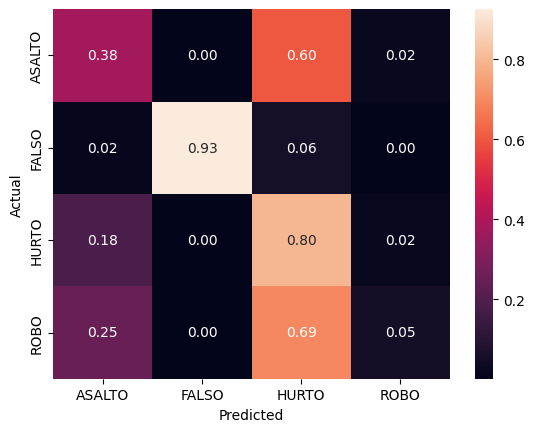

F1 score: 0.46 (+/- 0.00)


In [28]:
# one vs one random forest
ovo_rf = OneVsOneClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0))
ovo_rf.fit(X_train, y_train)
pred = ovo_rf.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(ovo_rf, X_valid, y_valid, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## XGBoost

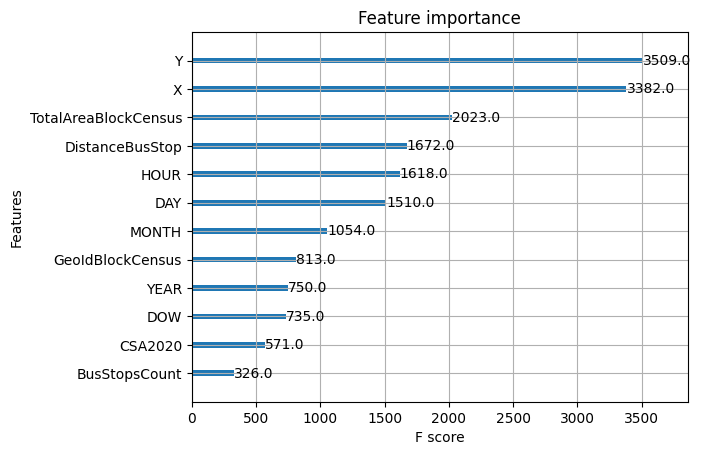

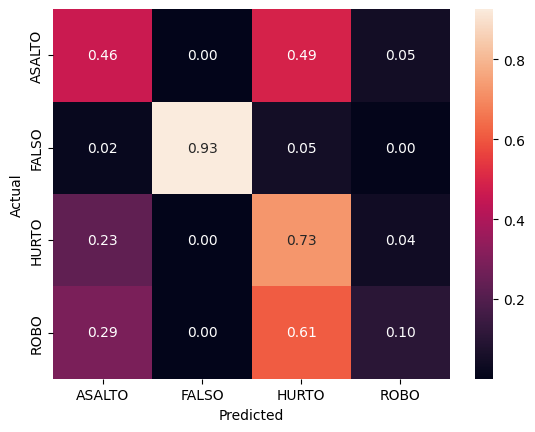

F1 score: 0.48 (+/- 0.00)


In [29]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_valid)
xgb.plot_importance(xgb_model)
plt.show()
cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt="0.2f", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(xgb_model, X_valid, y_valid, cv=3, scoring=f1_scorer)
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Grid Search

parameters = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

f1_scorer = make_scorer(f1_score, average='weighted')

grid_obj = GridSearchCV(xgb_model, parameters, scoring=f1_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

xgb_model = grid_obj.best_estimator_
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_valid)

cm = confusion_matrix(y_valid, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt="0.2f", xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

os.system("beep -f 555 -l 460")